# Tuning a Semantic Segmentation Transformers

We have now learned the power of the transformer architecture.
One of its applications is to perform semantic segmentation---
a computer vision task for associating each pixel in an image into a class or object.

Althgouh training a full transformer from scratch can be expensive, it is relatively easy to "tune" a pre-trained transformer to different types of data.
In this hands-on, we will use an [`implementation`](https://github.com/huggingface/transformers) of [SegFormer](https://arxiv.org/pdf/2105.15203.pdf) by [hugging face](https://huggingface.co/).

## Pre-trained Model

To run this hands-on with reasonable resources, we will use the [`MiT-b0`](https://huggingface.co/nvidia/mit-b0) variant of the SegFormer, 
which has only [3.7M parameters](https://huggingface.co/docs/transformers/en/model_doc/segformer).
Following the documentation, we can use it by the following steps.

**Step 1a.** Load the necessary python packages.

In [1]:
import requests       # for download image
from PIL import Image # for reading image
from transformers import SegformerImageProcessor, SegformerForImageClassification

**Step 1b.** Download a sample image and read it as a Pillow image.

In [2]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
img = Image.open(requests.get(url, stream=True).raw)

**Step 1c.** Download the pre-trained model and construct the image processor and classifier.

In [3]:
impro = SegformerImageProcessor.from_pretrained("nvidia/mit-b0")
model = SegformerForImageClassification.from_pretrained("nvidia/mit-b0")

/Users/ckc/.venv/dl/lib/python3.12/site-packages/transformers/models/segformer/image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


**Step 1d.** Process the input image and run it through the model. 

In [4]:
inputs  = impro(images=img, return_tensors="pt")
outputs = model(**inputs)

**Step 1e.** Obtain and print the predicted class---the model predicts one of the 1000 ImageNet classes

In [5]:
logits  = outputs.logits
predicted_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_idx])

Predicted class: tabby, tabby cat


**Exercise 1f.** Try to run the `MiT-b0` on a different image, maybe an astronomical image?
Does `MiT-b0` returns a good label?
If not, why?

*Hint:* what classes are in ImageNet?

## Semantic Segmentation

However, `SegFormer` was designed for semantic segmentation (as the [title of the paper](https://arxiv.org/abs/2105.15203) suggested).
Let's use `MiT-b0` as a semantic segmentation model.

**Step 2a.** Load the necessary python packages.

In [6]:
import numpy as np
from matplotlib   import pyplot as plt
from transformers import SegformerForSemanticSegmentation

**Step 2b.** Download the pre-trained model and construct the semantic segmentation model.

Note that there is a warning saying some weights were not initialized.
This is expected.
`SegFormer` consists of a hierarchical Transformer encoder and a lightweight all-Multilayer Perceptron (MLP) decode head.
The hierarchical Transformer is first pre-trained on ImageNet-1k, after which a decode head is added and fine-tuned altogether on a downstream dataset.
This hugging face repository only contains the pre-trained hierarchical Transformer, hence it can be used for fine-tuning purposes.

In [7]:
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0")

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Step 2c.** But as a demo, let's apply it to our image anyway.

In [8]:
outputs = model(**inputs)

**Step 2d.** The output of `SegFormer` is effectively an array containing an id for each pixel of the origin image.

In [9]:
segmap = impro.post_process_semantic_segmentation(outputs, target_sizes=[img.size[::-1]])[0].cpu().numpy()
display(segmap)

array([[552, 552, 552, ..., 320, 320, 320],
       [552, 552, 552, ..., 320, 320, 320],
       [552, 552, 552, ..., 320, 320, 320],
       ...,
       [214, 214, 214, ..., 464, 464, 464],
       [214, 214, 214, ..., 464, 464, 464],
       [214, 214, 214, ..., 464, 464, 464]])

**Step 3e.** We can overlay the segmentation map over the original image.
As we can see here, without tuning to down-stream data, `MiT-b0` can't really pull out objects from the image.

In [10]:
def getpalette(url="https://raw.githubusercontent.com/rndsrc/dl/main/ade_palette.txt"):
    s = requests.get(url).text
    a = np.fromstring(s, dtype=np.uint8, sep=' ')
    return a.reshape(-1,3)

palette = getpalette()

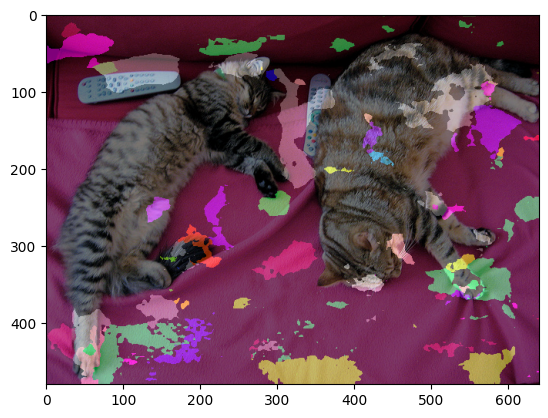

In [11]:
def segshow(img, mask, palette=palette, alpha=0.5):
    segcolor = np.zeros(mask.shape + (3,), dtype=np.uint8)
    for l, c in enumerate(palette):
        segcolor[mask==l, :] = c
    overlay = ((1-alpha)*np.array(img) + alpha*segcolor).astype(np.uint8)
    plt.imshow(overlay)

segshow(img, segmap)

**Exercise 2f.** Try to rerun the above cells, do you get the same segmentation?  Why?

## Tuning `SegFormer`

In [12]:
from torch.utils.data import Dataset
from astropy.io import fits

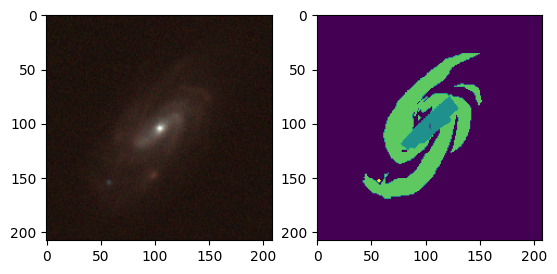

In [14]:
def normalize(a):
    a -= np.min(a)
    a *= 255 / np.max(a)
    return a.astype(np.uint8)

with fits.open("sample10/imagedata_1-118820.fits") as hdul:
    img = np.moveaxis(np.array([
        normalize(hdul[0].data),
        normalize(hdul[1].data),
        normalize(hdul[2].data),
    ]), 0, -1)

with fits.open("sample10/mask_1-118820.fits") as hdul:
    mask = np.array(hdul[0].data).astype(np.uint8)

fig, axes = plt.subplots(1,2)
axes[0].imshow(img)
axes[1].imshow(mask)

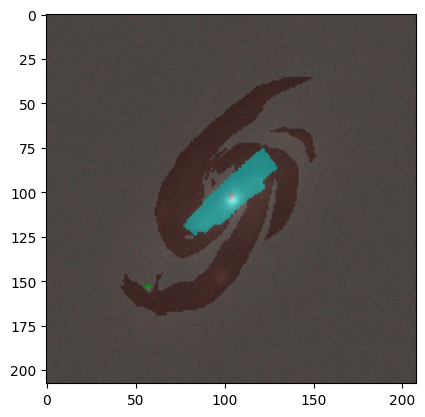

In [15]:
segshow(img, mask)